# Recurrent Neural Network for forecasting Lorenz system

Build a recurrent neural network (LSTM) with TensorFlow.

- Author: Guorui shen, adapted from script https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/recurrent_network.ipynb
- Project: https://github.com/aymericdamien/TensorFlow-Examples/
- Detailed description of this code https://jasdeep06.github.io/posts/Understanding-LSTM-in-Tensorflow-MNIST/
- sin(x)拟合https://www.cnblogs.com/pinking/p/9362966.html

## LSTM
References 
- https://en.wikipedia.org/wiki/LSTM
- picture resources https://www.cnblogs.com/pinking/p/9362966.html

The mathematical formulation of LSTM is
\begin{align}
&f_t = \sigma_g(W_fx_t+U_fh_{t-1}+b_f)\cr
&i_t = \sigma_g(W_ix_t+U_ih_{t-1}+b_i)\cr
&o_t = \sigma_g(W_ox_t+U_oh_{t-1}+b_o)\cr
&g_t = \sigma_c(W_cx_t+U_ch_{t-1}+b_c)
\end{align}
and then
\begin{align}
&c_t = f_t\circ c_{t-1}+i_t\circ g_t\cr
&h_t = o_t\circ \sigma_h(c_t)
\end{align}

where the initial values are $c_{0}=0$ and $h_{0}=0$, $c_t\in R^h, h_t\in R^h$, $f_t, i_t, o_t, g_t$ are "forget, input, output, gate" at time $t$, respectively. The LSTM cell is unrolled many times, say $T$, which means $t=1, 2, \cdots, T$. The LSTM is shown as 

<img src="lstm.png" alt="sturcture of a lstm unit" style="width: 500px;"/>

### Forget Gate
<p align="center">
  <img src="https://github.com/suzyi/images/blob/master/forget-gate.png", alt="output gate", width=500px,height＝500px>
</p>

### Input Gate and  Gate Gate?
<p align="center">
  <img src="https://github.com/suzyi/images/blob/master/input-gate.png", alt="output gate", width=500px,height＝500px>
</p>
<p align="center">
  <img src="https://github.com/suzyi/images/blob/master/gate-gate.png", alt="output gate", width=500px,height＝500px>
</p>
### Output Gate
<p align="center">
  <img src="https://github.com/suzyi/images/blob/master/output-gate.png", alt="output gate", width=500px,height＝500px>
</p>
and finally, the information of all inputs $x_1, x_2, \cdots, x_{timesteps}$ are accumulated into $h_{timesteps}$ when the lstm unit was unrolled timesteps times.

Both two pictures are from Stanford, Feifei-Li et al slides.

## RNN Overview

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" alt="nn" style="width: 600px;"/>

where $A$ in this picture represents a LSTM unit.

References:
- [Long Short Term Memory](http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf), Sepp Hochreiter & Jurgen Schmidhuber, Neural Computation 9(8): 1735-1780, 1997.

In [1]:
from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib import rnn

import scipy.io as sio
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
tf.set_random_seed(3)

In [2]:
class Dataset:

    def __init__(self,data):
        self._index_in_epoch = 0
        self._epochs_completed = 0
        self._data = data
        self._num_examples = data.shape[0]
        pass

    @property
    def data(self):
        return self._data

    def next_batch(self,batch_size,shuffle = True):
        start = self._index_in_epoch
        if start == 0 and self._epochs_completed == 0:
            idx = np.arange(0, self._num_examples)  # get all possible indexes
            np.random.shuffle(idx)  # shuffle indexe
            self._data = self.data[idx]  # get list of `num` random samples

        # go to the next batch
        if start + batch_size > self._num_examples:
            self._epochs_completed += 1
            rest_num_examples = self._num_examples - start
            data_rest_part = self.data[start:self._num_examples]
            idx0 = np.arange(0, self._num_examples)  # get all possible indexes
            np.random.shuffle(idx0)  # shuffle indexes
            self._data = self.data[idx0]  # get list of `num` random samples

            start = 0
            self._index_in_epoch = batch_size - rest_num_examples #avoid the case where the #sample != integar times of batch_size
            end =  self._index_in_epoch  
            data_new_part =  self._data[start:end]  
            return np.concatenate((data_rest_part, data_new_part), axis=0)
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch
            return self._data[start:end]

In [4]:
num_discard = 800
lrz = sio.loadmat('Lorenz.mat')
lrz['states'] = lrz['states'][num_discard:,:]
lrz['t'] = lrz['t'][0][num_discard:]
print(len(lrz['states']), len(lrz['states'][0]))

5200 3


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,u't')

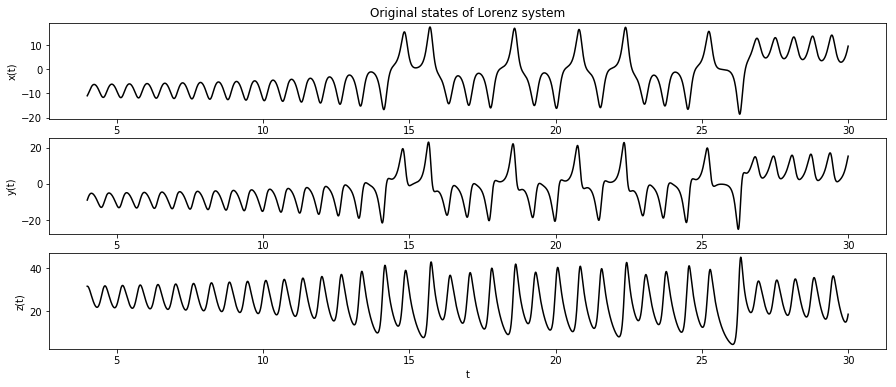

In [5]:
ylabel = ['x(t)', 'y(t)', 'z(t)']
plt.figure(figsize=(15, 6))
plt.subplot(311)
plt.title('Original states of Lorenz system')
for i in range(3):
    plt.subplot(311+i)
    plt.plot(lrz['t'], lrz['states'][:, i], 'k-')
    plt.ylabel(ylabel[i])
plt.xlabel('t')

In [6]:
# Training Parameters
learning_rate = 0.001
training_steps = 10000
display_step = 1000
batch_size = 32

# Network Parameters
num_input = 3
timesteps = 20  # timesteps
num_hidden = 400 # the number of hidden nodes
num_output = 3  # dimension of Lorenz system
num_train = 2000 # number of training examples
num_pred = 300  # number of prediction steps

# tf Graph input
X = tf.placeholder("float", [None, timesteps, num_input])
Y = tf.placeholder("float", [None, num_output])

In [7]:
# build features and labels
train_input = np.empty(shape = (0, timesteps*num_input))
train_output = np.empty(shape = (0, num_output))
for i in range(num_train):
    train_input = np.vstack((train_input, lrz['states'][i:timesteps+i,:].reshape(1, timesteps*num_input)))
    train_output = np.vstack((train_output, lrz['states'][timesteps+i,:]))
print(train_input.shape, train_output.shape)

train_data = np.hstack((train_input, train_output))
train_data = Dataset(train_data)

test_input = lrz['states'][num_train:timesteps+num_train,:].reshape(1, timesteps, num_input)
states_test = lrz['states'][timesteps+num_train:timesteps+num_train+num_pred,:]
states_train = lrz['states'][timesteps+num_train-int(1.5*num_pred):timesteps+num_train, :]
t_test = lrz['t'][timesteps+num_train:timesteps+num_train+num_pred]
t_train = lrz['t'][timesteps+num_train-int(1.5*num_pred):timesteps+num_train]

(2000, 60) (2000, 3)


In [8]:
# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_output]))
}

In [9]:
def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    """
    input:
        x: (num, timesteps, n_input)
    
    output:(num, num_output)
    """
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)

    # Get lstm cell output
    h_t, c_t = rnn.static_rnn(lstm_cell, x, dtype=tf.float32) # x is of (timesteps, batch_size, num_input)
    outputs, states = h_t, c_t # where both h_t and c_t are of size (timesteps, batch_size, num_hidden)

    # Linear activation, using rnn inner loop last output
    return tf.add(tf.matmul(outputs[-1], weights['out']), biases['out'])

In [10]:
prediction = RNN(X, weights, biases)

# Define loss and optimizer
loss_op = tf.losses.mean_squared_error(prediction, Y)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [11]:
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        data_batch = train_data.next_batch(batch_size)
        batch_features, batch_labels = data_batch[:, :timesteps*num_input], data_batch[:, timesteps*num_input:]
        batch_features = batch_features.reshape(-1, timesteps, num_input)

        sess.run(train_op, feed_dict={X: batch_features, Y: batch_labels})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss = sess.run(loss_op, feed_dict={X: batch_features, Y: batch_labels})
            print("Step " + str(step) + ", Batch Loss= " + "{:.4f}".format(loss))

    print("Optimization Finished!")
    
    states_predict = np.empty(shape=(0, num_output))
    for i in range(num_pred):
        temp = sess.run(prediction, feed_dict={X: test_input})
        states_predict = np.vstack((states_predict, temp))
        test_input = np.vstack((test_input[0][1:,:], temp)).reshape(1,timesteps,num_input)        
    print("Prediction Finished!")

Step 1, Batch Loss= 3128.8606
Step 1000, Batch Loss= 0.1682
Step 2000, Batch Loss= 0.0386
Step 3000, Batch Loss= 0.0110
Step 4000, Batch Loss= 0.0422
Step 5000, Batch Loss= 0.0105
Step 6000, Batch Loss= 0.0130
Step 7000, Batch Loss= 0.0020
Step 8000, Batch Loss= 0.0076
Step 9000, Batch Loss= 0.0218
Step 10000, Batch Loss= 0.0024
Optimization Finished!
Prediction Finished!


Mean square prediction error for 300 steps is 183.8515


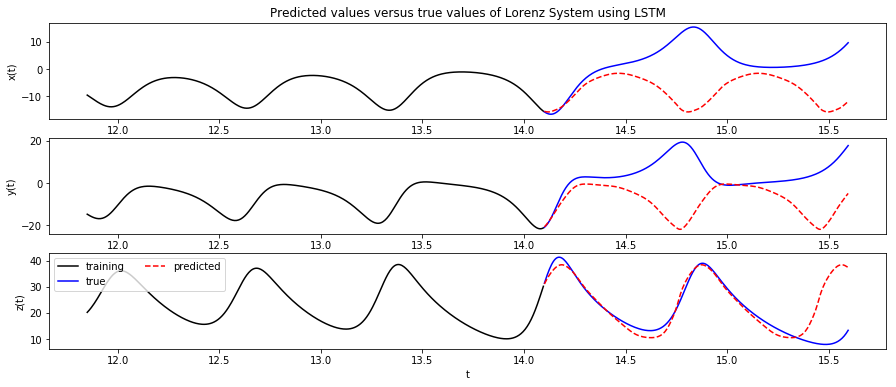

In [12]:
# visualize prediction results
print("Mean square prediction error for " + str(num_pred) + " steps is " \
      + "{:.4f}".format(sum(sum(np.square(states_predict - states_test)))/(num_pred*num_output)))

plt.figure(figsize=(15, 6))
plt.subplot(311)
plt.title('Predicted values versus true values of Lorenz System using LSTM')
for i in range(num_input):
    plt.subplot(311+i)
    plt.plot(t_train, states_train[:, i], 'k-', t_test, states_test[:, i], 'b-', t_test, states_predict[:, i], 'r--')
    plt.ylabel(ylabel[i])
plt.xlabel('t')
plt.legend(["training", "true", "predicted"], loc = 0, ncol = 2)